# Machine Learning Model ANN with Grid Search

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(15,10)})
warnings.filterwarnings('ignore')

### Basic implementation of the model

In [2]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [3]:
# Dataset generated in previous phase
data = pd.read_csv('./data_f1/cleaned_data.csv')

In [4]:
x = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliability','active_driver','active_constructor']]

In [5]:
x = x[x['active_constructor']==1]
x = x[x['active_driver']==1]

In [6]:
sc  = StandardScaler()
le = LabelEncoder()
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
X = x.drop(['position','active_driver','active_constructor'],1)
y = x['position'].apply(lambda x: position_index(x))

In [7]:
# Separate the test data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
MLP = MLPClassifier()
MLP.fit(X_train, y_train)

MLPClassifier()

In [9]:
y_pred = MLP.predict(X_test)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 71


In [10]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.914


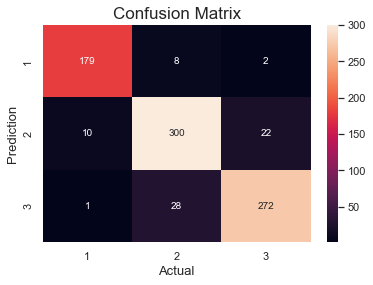

In [11]:
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['1','2','3'], yticklabels=['1','2','3'])

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

### Hyperparameter tuning with GridSearch

In [12]:
param_grid = {
    'hidden_layer_sizes': [100, 200],
    'max_iter': [200, 250],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver':  ['lbfgs','sgd','adam']
}

In [13]:
# Define the scoring metric to use for evaluation
scoring = 'accuracy'
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=MLP, param_grid=param_grid, scoring=scoring, cv=3, verbose=2)

In [14]:
# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=lbfgs; total time=   0.3s
[CV] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=lbfgs; total time=   0.4s
[CV] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=lbfgs; total time=   0.5s
[CV] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=sgd; total time=   0.4s
[CV] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=sgd; total time=   0.3s
[CV] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=sgd; total time=   0.3s
[CV] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=adam; total time=   0.1s
[CV] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=adam; total time=   0.3s
[CV] END activation=identity, hidden_layer_sizes=100, max_iter=200, solver=adam; total time=   0.2s
[CV] END activation=identity, hidden_l

GridSearchCV(cv=3, estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [100, 200],
                         'max_iter': [200, 250],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='accuracy', verbose=2)

In [15]:
# Print the best hyperparameters and the best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'activation': 'tanh', 'hidden_layer_sizes': 200, 'max_iter': 250, 'solver': 'adam'}
Best score: 0.9232465500071134


In [16]:
# Re-train the model with the best hyperparameters
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=200, max_iter=250)

In [17]:
y_pred = best_clf.predict(X_test)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 64


In [18]:
 # Test the model with the best hyperparameters on the testing data
accuracy = best_clf.score(X_test, y_test)
print("Testing accuracy:", accuracy)

Testing accuracy: 0.9221411192214112


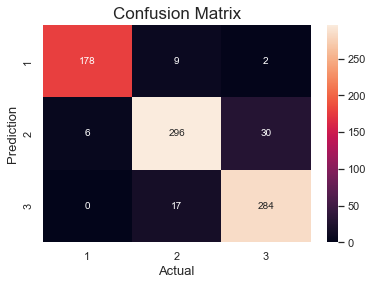

In [19]:
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['1','2','3'], yticklabels=['1','2','3'])

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()